In [124]:
#https://medium.com/@zahrahafida.benslimane/audio-source-separation-using-non-negative-matrix-factorization-nmf-a8b204490c7d

In [112]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import librosa
import librosa.display
import os
from scipy.io import wavfile

In [113]:
os.chdir(f"C:\\Users\griff\AFRL_2024")

In [114]:
file = "d302sA1r01p0120210823.wav"

In [115]:
audio, sr = librosa.load(file)

C:\Users\griff\AppData\Local\Temp\ipykernel_6796\3656246991.py:2: FutureWarning: waveshow() keyword argument 'x_axis' has been renamed to 'axis' in version 0.10.0.
	This alias will be removed in version 1.0.
  librosa.display.waveshow(audio, sr=sr, ax=ax,x_axis='time')
C:\Users\griff\AppData\Local\Temp\ipykernel_6796\3656246991.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


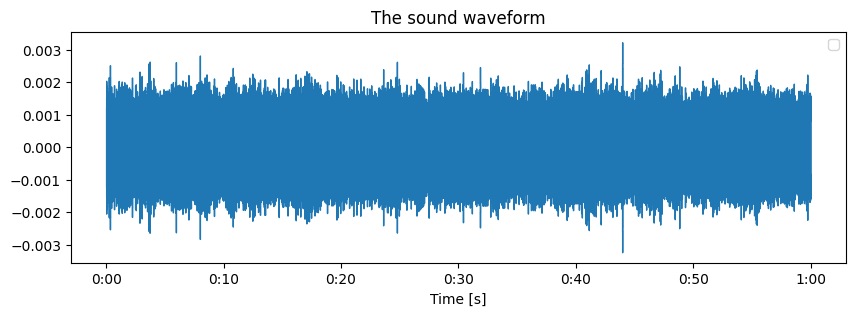

In [116]:
fig, ax = plt.subplots(figsize=(10, 3))
librosa.display.waveshow(audio, sr=sr, ax=ax,x_axis='time')
ax.set(title='The sound waveform', xlabel='Time [s]')
ax.legend()
plt.show()

Text(0.5, 1.0, 'audio spectrogram')

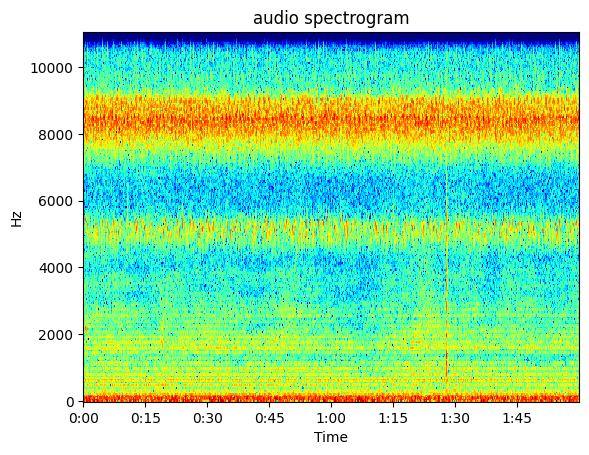

In [117]:
stft = librosa.stft(audio, n_fft = 512, hop_length= 256)
stftMag = np.abs(stft)
stftAngle = np.angle(stft)

spec = librosa.amplitude_to_db(stftMag, ref = np.max)
librosa.display.specshow(spec, y_axis='hz', sr=sr, x_axis='time', cmap=matplotlib.cm.jet)
plt.title('audio spectrogram')

In [118]:
def divergence(V,W,H,beta=2):
    if beta == 0 : return np.sum( V/(W@H) - math.log10(V/(W@H)) -1 )
    
    if beta == 1 : return np.sum( V*math.log10(V/(W@H)) + (W@H - V))
    
    if beta == 2 : return 1/2*np.linalg.norm(W@H-V)

In [119]:
def NMF(V, S, beta = 2,  threshold = 0.001, MAXITER = 10000): 
    
    """
    inputs : 
    --------
        V         : Mixture signal : |TFST|
        S         : The number of sources to extract
        beta      : Beta divergence considered, default=2 (Euclidean)
        threshold : Stop criterion 
        MAXITER   : The number of maximum iterations, default=1000                                                     
    
    outputs :
    ---------
        W : dictionary matrix [KxS], W>=0
        H : activation matrix [SxN], H>=0
        cost_function : the optimised cost function over iterations
       
   Algorithm : 
   -----------
   
    1) Randomly initialize W and H matrices
    2) Multiplicative update of W and H 
    3) Repeat step (2) until convergence or after MAXITER   
    """
    
    counter = 0
    cost_function = []
    beta_divergence = 1
    
    K, N = np.shape(V)
    
    # Initialisation of W and H matrices : The initialization is generally random
    W = np.abs(np.random.normal(loc=0, scale = 2.5, size=(K,S)))    
    H = np.abs(np.random.normal(loc=0, scale = 2.5, size=(S,N)))

    while beta_divergence >= threshold and counter <= MAXITER:
        
        # Update of W and H
        H *= (W.T@(((W@H)**(beta-2))*V))/(W.T@((W@H)**(beta-1)) + 10e-10)
        W *= (((W@H)**(beta-2)*V)@H.T)/((W@H)**(beta-1)@H.T + 10e-10)
        
        # Compute cost function
        beta_divergence =  divergence(V,W,H, beta = 2)
        cost_function.append( beta_divergence )
        counter += 1
       
    return W,H, cost_function

Text(0, 0.5, 'Beta Divergence for beta = 2 ')

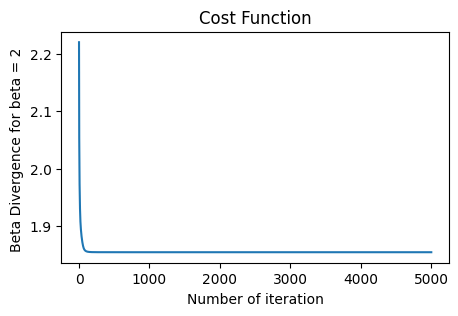

In [120]:
V = stftMag + 1e-10
beta = 2
S = 2

W, H, cost_function = NMF(V,S,beta = beta, threshold = 0.05, MAXITER = 5000) 

plt.figure(figsize=(5,3))
plt.plot(cost_function)
plt.title("Cost Function")
plt.xlabel("Number of iteration")
plt.ylabel(f"Beta Divergence for beta = {beta} ")

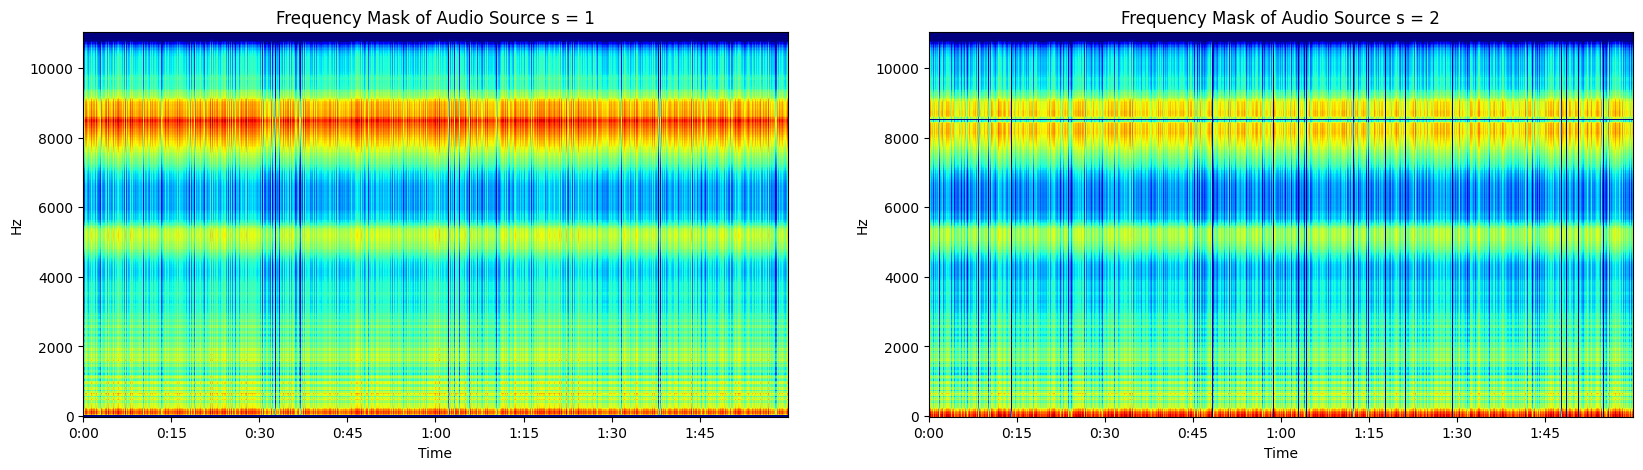

In [121]:
#After NMF, each audio source S can be expressed as a frequency mask over time
f, axs = plt.subplots(nrows=1, ncols=S,figsize=(20,5))
filtered_spectrograms = []
for i in range(S):
    axs[i].set_title(f"Frequency Mask of Audio Source s = {i+1}") 
    # Filter eash source components
    filtered_spectrogram = W[:,[i]]@H[[i],:]
    # Compute the filtered spectrogram
    D = librosa.amplitude_to_db(filtered_spectrogram, ref = np.max)
    # Show the filtered spectrogram
    librosa.display.specshow(D,y_axis = 'hz', sr=sr,x_axis ='time',cmap= matplotlib.cm.jet, ax = axs[i])
    
    filtered_spectrograms.append(filtered_spectrogram)

In [122]:
reconstructed_sounds = []
for i in range(S):
    reconstruct = filtered_spectrograms[i] * np.exp(1j*stftAngle)
    new_sound   = librosa.istft(reconstruct)
    reconstructed_sounds.append(new_sound)

C:\Users\griff\AppData\Local\Temp\ipykernel_6796\1330027115.py:5: FutureWarning: waveshow() keyword argument 'x_axis' has been renamed to 'axis' in version 0.10.0.
	This alias will be removed in version 1.0.
  librosa.display.waveshow(reconstructed_sounds[i], sr=sr, color = "r", ax=ax[i],label=f'Source {i}',x_axis='time')


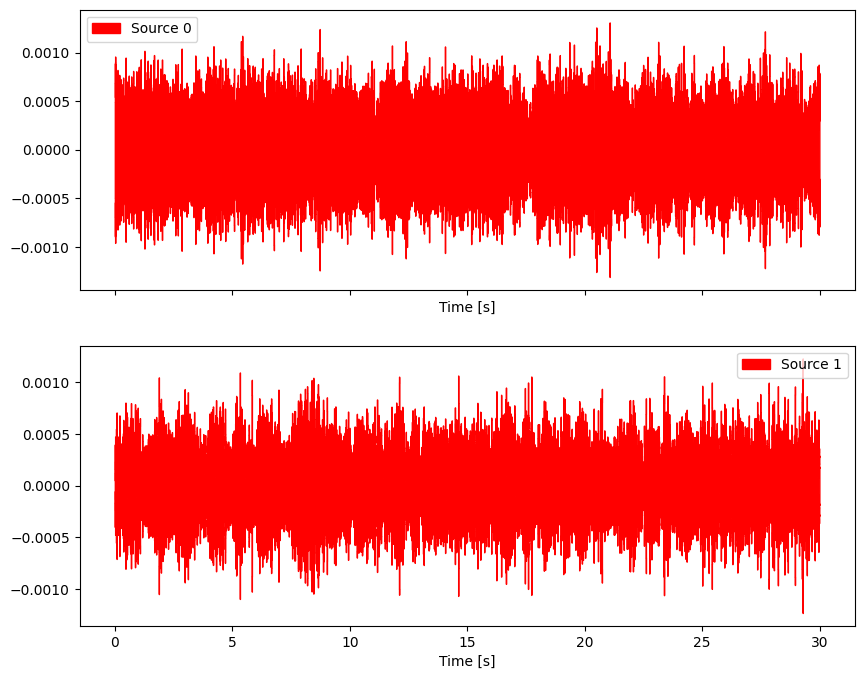

In [123]:
# Tracing the waveform
colors = ['r', 'g','b']
fig, ax = plt.subplots(nrows=S, ncols=1, sharex=True, figsize=(10, 8))
for i in range(S):
    librosa.display.waveshow(reconstructed_sounds[i], sr=sr, color = "r", ax=ax[i],label=f'Source {i}',x_axis='time')
    ax[i].set(xlabel='Time [s]')
    ax[i].legend()
    wavfile.write("processed/" + file + str(i) + "_NMF_beta" + str(beta) + ".wav", sr, reconstructed_sounds[i])